# Predicting RWRA Scores with Remotely Sensed Features

**Author**: Bryce A Young, Research Assistant  
**Institution**: University of Montana, National Center for Landscape Fire Analysis

**Created**: 2025-02-27  
**Modified**: 2025-02-27

### Overview  
In previous notebooks (located in this repository), I prepared data (`data_prep/`), attributed that data to homes and home ignition zones (`ouray_hiz.ipynb`), and performed extensive analysis on features from tax assessor data (`tax_analysis.ipynb`), remotely-sensed data (`hiz_analysis.ipynb`, `wui_analysis.ipynb`), and rapid wildfire risk assessment data (`risk_data_analysis.ipynb`).

In this notebook, I explore different machine learning models for using the features I attributed to homes to predict RWRA scores. 

This notebook is organized by the following workflow:
1. Feature selection
2. Risk score prediction with Random Forest
3. Model validation
4. Explore different features and machine learning models

## Step 1: Feature Selection
---

In [51]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(out, 'figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

In [52]:
import geopandas as gpd
import pandas as pd

# Read in data
gdf = gpd.read_file(os.path.join(out, 'feat_risk_refact.gpkg'), layer='full')
# Change geodataframe to regular dataframe by dropping geometry column
df = gdf.drop(columns=['geometry'], axis=1)
pd.set_option('display.max_columns', None)
df.head()


,rwra_index,feat_index,parcel_num,Year,address,ParcelNum,Model,Address_Visible,Driveway_Clearance,Driveway_Lenth,Dist_to_Danger_Topo,Slope_Final,Background_Fuels,Defensible_Space,Roofing_Material,Building_Exterior,Other_Combustibles,Decks_and_Fencing,Proximity_to_Neighboring_Home,Ingress_Egress,Score_Final,Risk_Rating,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,Actual Year Built\n(AYB),Air Conditioning\n(AIRC),Architecture Style\n(ARCH),Area Acres\n(Area_ACRES),Area SQFT\n(Area_SQFT),Condition\n(COND),DGR - Detached Garage\n(SubArea_DGR),Effective Year Built\n(EYB),Exterior Percent\n(EXW_PERCENT),Exterior Wall\n(EXW),Floor\n(FLR),Frame\n(FRME),Heating Fuel\n(HTFL),Interior Wall\n(INT),Neighborhood\n(NBHD),OPP - Open Porch\n(SubArea_OPP),PTO - Patio\n(SubArea_PTO),RMS\n(RMS),Roof Cover\n(RCVR),Roof Structure\n(RSTR),Type,WBL - Wood Balcony\n(SubArea_WBL),sum_cc
0,0,2836,430506210001,2013.0,123 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,75,75,0,0,10,50,NaN,10,225.0,High,Ouray County,1,31.525324,0.028983,0.080487,0.112609,0.179108,1,430506210001,R003918,49.6527,True,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,15 - STONE,11 - CONCRETE,9 - FRME 2X4,7 - PROPANE,5 - GOOD,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.401187
1,1,1110,430506210001,2013.0,129 EXAMPLE DRIVE,430506210001,A,0,5,NaN,0,NaN,50,50,0,20,10,0,NaN,0,135.0,Low,Ouray County,1,31.525324,0.051442,0.096132,0.093393,0.155315,1,430506210001,R003918,49.6527,False,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,15 - STONE,11 - CONCRETE,9 - FRME 2X4,7 - PROPANE,5 - GOOD,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.396283
2,2,3672,430506210001,2013.0,135 EXAMPLE DRIVE,430506210001,A,0,5,NaN,75,NaN,50,100,0,60,10,50,NaN,10,360.0,Extreme,Ouray County,1,66.164004,0.035089,0.059277,0.031211,0.026098,0,430506210001,R003918,49.6527,True,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,15 - STONE,11 - CONCRETE,9 - FRME 2X4,7 - PROPANE,5 - GOOD,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.151675
3,3,3843,430506210001,2013.0,141 EXAMPLE DRIVE,430506210001,A,0,0,NaN,0,NaN,50,75,200,60,30,0,NaN,0,415.0,Extreme,Ouray County,1,78.033957,0.054498,0.065344,0.076959,0.213781,0,430506210001,R003918,49.6527,False,2008.0,1 - NONE,COMMERCIAL,0.0,6991.1,3 - GOOD,0.0,2015.0,10.0,15 - STONE,11 - CONCRETE,9 - FRME 2X4,7 - PROPANE,5 - GOOD,5000591 - LHV TR 35+,327.4,0.0,0.776148,METAL,GABLE,Commercial,0.0,0.410582
4,5,921,403935100181,2017.0,416 COUNTY ROAD 22A,403935100181,B,5,0,11.0,0,0.0,10,50,0,0,0,0,0.0,0,76.0,Low,Ouray County,1,211.505051,0.048738,0.084885,0.034318,0.000000,0,403935100181,R000531,32.7283,False,2012.0,1 - NONE,SINGLE STORY,0.0,4034.9,3 - GOOD,0.0,2015.0,100.0,26 - CONCRETE SIDING,1 - WDJST PLYW,9 - FRME 2X4,3 - GAS,1 - DRYWALL,7000006 - Outlying6,572.0,215.0,0.776148,ASPHALT,GABLE,Residence,0.0,0.167940


In [53]:
df.columns

Index(['rwra_index', 'feat_index', 'parcel_num', 'Year', 'address',
       'ParcelNum', 'Model', 'Address_Visible', 'Driveway_Clearance',
       'Driveway_Lenth', 'Dist_to_Danger_Topo', 'Slope_Final',
       'Background_Fuels', 'Defensible_Space', 'Roofing_Material',
       'Building_Exterior', 'Other_Combustibles', 'Decks_and_Fencing',
       'Proximity_to_Neighboring_Home', 'Ingress_Egress', 'Score_Final',
       'Risk_Rating', 'County', 'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Actual Year Built\n(AYB)', 'Air Conditioning\n(AIRC)',
       'Architecture Style\n(ARCH)', 'Area Acres\n(Area_ACRES)',
       'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
       'DGR - Detached Garage\n(SubArea_DGR)', 'Effective Year Built\n(EYB)',
       'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
       'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)'

In [57]:
# Create prediction dataframe 1 - numeric - min cols
pred1 = df[
    [
    'Score_Final',
    'min_ssd', 
    'intersections', 
    'sum_cc', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)'
    ]
]

# prediction df 2 - numeric - added different canopy closure classes instead of sum_cc
pred2 = df[
    [
    'Score_Final',
    'min_ssd', 
    'intersections', 
    'mean_cc0_2m',
    'mean_cc2_4m', 
    'mean_cc4_8m', 
    'mean_cc8_40m', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)'
    ]
]

# prediction df 3 - mix of numeric and categorical data from tax assessor only
pred3 =  df[
    [
    'Score_Final',
    'Actual Year Built\n(AYB)', 'Air Conditioning\n(AIRC)',
    'Architecture Style\n(ARCH)', 'Area Acres\n(Area_ACRES)',
    'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
    'DGR - Detached Garage\n(SubArea_DGR)', 'Effective Year Built\n(EYB)',
    'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
    'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)',
    'Interior Wall\n(INT)', 'Neighborhood\n(NBHD)',
    'OPP - Open Porch\n(SubArea_OPP)', 'PTO - Patio\n(SubArea_PTO)',
    'RMS\n(RMS)', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type',
    'WBL - Wood Balcony\n(SubArea_WBL)'
    ]
]

# prediciton df 4 - my favorite columns (mixed numeric and categorical data)
pred4 = df[
    [
    'Score_Final',
    'wui_class',
    'hiz_ext_out',
    'min_ssd', 
    'intersections', 
    'sum_cc', 
    'ACRES_calc', 
    'Area SQFT\n(Area_SQFT)',
    'Effective Year Built\n(EYB)',
    'RMS\n(RMS)',
    'Architecture Style\n(ARCH)',
    'Condition\n(COND)',
    'Exterior Wall\n(EXW)',
    'Heating Fuel\n(HTFL)',
    'Roof Cover\n(RCVR)', 
    'Roof Structure\n(RSTR)'
    ]
]

# prediction df 5 - all columns
pred5 = df[
    [
    'Score_Final',
       'wui_class', 'min_ssd', 'mean_cc0_2m',
       'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m', 'intersections',
       'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Actual Year Built\n(AYB)', 'Air Conditioning\n(AIRC)',
       'Architecture Style\n(ARCH)', 'Area Acres\n(Area_ACRES)',
       'Area SQFT\n(Area_SQFT)', 'Condition\n(COND)',
       'DGR - Detached Garage\n(SubArea_DGR)', 'Effective Year Built\n(EYB)',
       'Exterior Percent\n(EXW_PERCENT)', 'Exterior Wall\n(EXW)',
       'Floor\n(FLR)', 'Frame\n(FRME)', 'Heating Fuel\n(HTFL)',
       'Interior Wall\n(INT)', 'Neighborhood\n(NBHD)',
       'OPP - Open Porch\n(SubArea_OPP)', 'PTO - Patio\n(SubArea_PTO)',
       'RMS\n(RMS)', 'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type',
       'WBL - Wood Balcony\n(SubArea_WBL)', 'sum_cc'
    ]
]

We're going to determine feature importance with a random forest. First, let's split the data into training and testing. 

In [58]:
from sklearn.model_selection import train_test_split

# Define train-test split function
def split_data(df):
    X = df.drop(columns=['Score_Final'])
    y = df['Score_Final']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Apply to all datasets
X_train1, X_test1, y_train1, y_test1 = split_data(pred1)
X_train2, X_test2, y_train2, y_test2 = split_data(pred2)
X_train3, X_test3, y_train3, y_test3 = split_data(pred3)
X_train4, X_test4, y_train4, y_test4 = split_data(pred4)
X_train5, X_test5, y_train5, y_test5 = split_data(pred5)


## Step 2: Random Forest Regressor
---

In [59]:
## PRED 1 ##

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train Random Forest on pred1 (repeat for pred2)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train1, y_train1)

# Get feature importance
importances = pd.DataFrame({'Feature': X_train1.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Display results
importances

,Feature,Importance
3,ACRES_calc,0.266799
2,sum_cc,0.212950
4,Area SQFT\n(Area_SQFT),0.209981
0,min_ssd,0.202148
5,Effective Year Built\n(EYB),0.058178
6,RMS\n(RMS),0.037653
1,intersections,0.012290


In [60]:
## PRED 2 ## 

rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(X_train2, y_train2)

importances2 = pd.DataFrame({'Feature': X_train2.columns, 'Importance': rf2.feature_importances_})
importances2 = importances2.sort_values(by='Importance', ascending=False)

importances2

,Feature,Importance
6,ACRES_calc,0.214746
7,Area SQFT\n(Area_SQFT),0.135776
2,mean_cc0_2m,0.135690
0,min_ssd,0.135620
4,mean_cc4_8m,0.116404
5,mean_cc8_40m,0.103020
3,mean_cc2_4m,0.093475
8,Effective Year Built\n(EYB),0.039105
9,RMS\n(RMS),0.018990
1,intersections,0.007176


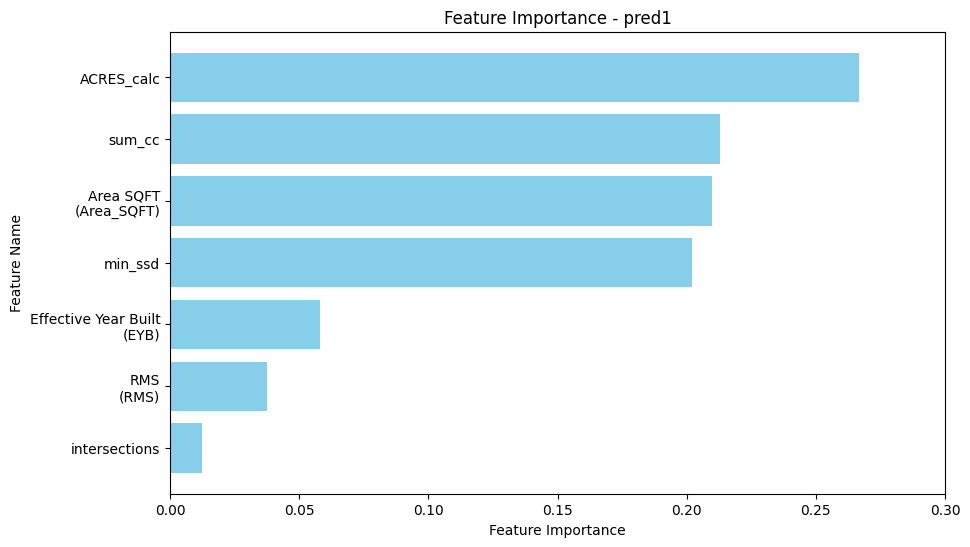

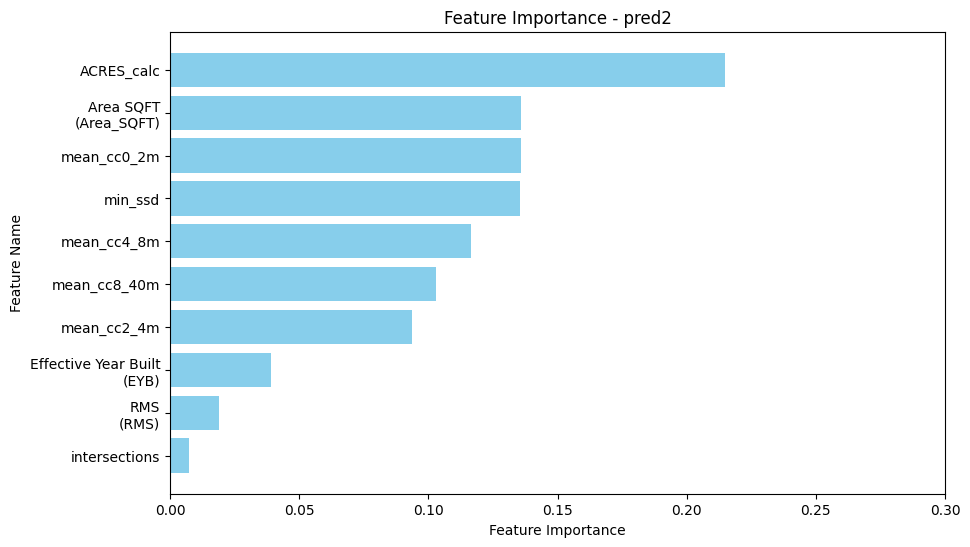

In [62]:
import matplotlib.pyplot as plt

# Function to plot feature importance
def plot_feature_importance(importances, title):
    plt.figure(figsize=(10, 6))
    plt.barh(importances['Feature'], importances['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(title)
    plt.xlim(0, 0.3)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

# Plot feature importance for pred1
plot_feature_importance(importances, "Feature Importance - pred1")

# Plot feature importance for pred2
plot_feature_importance(importances2, "Feature Importance - pred2")

I'm dissapointed to see that the largest predictor of risk score is the property acreage. It's good to know, but I don't think this model is going to work very well :(

Let's evaluate how each model is performing here.

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate RF model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        "Dataset": dataset_name,
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
    }
    
    return metrics

# Evaluate models for pred1 and pred2
results = []
results.append(evaluate_model(rf, X_train1, X_test1, y_train1, y_test1, "pred1"))
results.append(evaluate_model(rf2, X_train2, X_test2, y_train2, y_test2, "pred2"))

import pandas as pd
results_df = pd.DataFrame(results)

results_df

,Dataset,Train R²,Test R²,Test MAE,Test MSE
0,pred1,0.881617,0.228703,105.097857,23503.143327
1,pred2,0.883672,0.204017,104.336964,24255.366370


The model is definitely overfitting - you can see in the difference between train r^2 and test r^2. So what I'm going to do is go back and tune the hyperparameters in the RandomForestRegressor function. Then we'll try again.

## Validation

Let's create a confusion matrix of prediction labels and true labels and plot it in a heat map to visualize how close we came.

We will get precision, recall and f1 score for each class.

Let's produce an ROC curve for each class in the model

## Ordinal analysis
Let's convert the target variable to ordinal. Then we can create a confusion matrix and extract the cumulative metrics. Then we extract the cumulative precision across ordinal classes.

## Classification by Logistic Regression

Here we import the data and plot to see whether logistic regression is appropriate for the analysis. We do this with continuous variables.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit as strat
import matplotlib.pyplot as plt

# Read the data into the script
df = pd.read_csv('A3_Q1_data.csv')

# Convert df to numpy array
data = df.values

# Extract features and labels
X = data[:, :-1]  # Features x_1 and x_2
y = data[:, -1]   # Labels y

# Create stratified split
split = strat(n_splits=1, test_size=0.3, random_state=42)

# Perform the split
for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# See the split outcome for confirmation
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Plot the training data by class
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='orchid', label='Class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='steelblue', label='Class 1')

plt.xlabel('Feature x_1')
plt.ylabel('Feature x_2')
plt.title('Training Data by Class')
plt.legend()
plt.show()

In [ ]:
# Calculations for x_1
x1_mean = np.mean(X_train[:, 0])
x1_std = np.std(X_train[:, 0])
x1_range = np.ptp(X_train[:, 0])

# Calculations for x_2
x2_mean = np.mean(X_train[:, 1])
x2_std = np.std(X_train[:, 1])
x2_range = np.ptp(X_train[:, 1])

# Print the results
print("Feature x_1:")
print(f"Mean: {x1_mean: .4f}, Standard Deviation: {x1_std: .4f}, Range: {x1_range: .4f}")
print("\nFeature x_2:")
print(f"Mean: {x2_mean: .4f}, Standard Deviation: {x2_std: .4f}, Range: {x2_range: .4f}")

If logistic regression is appropriate for this analysis, refer to  assignment 3 for fitting, gradient descent, AUC and precision-recall.